### Assignment 2 ###
### Name - Pranav Gupta ###
### Roll No. - 2021101095 ###

In [1]:
import cv2
import numpy as np
from sklearn import svm
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import wandb

/home2/rkada/miniconda3/envs/deepfont/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 1. SIFT-BoVW-SVM ####

In [ ]:
np.random.seed = 42
torch.manual_seed = 42
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

##### 1.1 Implementation of BoVW Approach #####

In [ ]:
def extract_sift_features(image):
    image = np.uint8(image)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def cluster_sift_descriptors(descriptors, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(descriptors)
    return kmeans, kmeans.cluster_centers_

def image_histogram_represent(image, kmeans, num_clusters, cluster_centers):
    image = np.uint8(image)
    keypoints, descriptors = extract_sift_features(image)
    histogram = np.zeros(num_clusters)
    if descriptors is not None:
        for descriptor in descriptors:
            distances = np.linalg.norm(cluster_centers - descriptor, axis=1)
            closest_visual_word_index = np.argmin(distances)
            histogram[closest_visual_word_index] += 1
    return histogram

In [ ]:
y_train = []
for image, label in train_dataset:
    y_train.append(label)

y_test = []
for image, label in test_dataset:
    y_test.append(label)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Feature Extraction from Training images
descriptors = []
for i in range(train_dataset.data.shape[0]):
    keypoints, desc = extract_sift_features(train_dataset.data[i])
    if desc is not None:
        for i in range(len(desc)):
            descriptors.append(desc[i])

In [ ]:
# Fit K-Means on the obtained Descriptors
k = 50
kmeans, cluster_centers = cluster_sift_descriptors(np.array(descriptors), k)

# Represent Train images as histograms
svm_train = []
for i in range(train_dataset.data.shape[0]):
    histogram = image_histogram_represent(train_dataset.data[i], kmeans, k, cluster_centers=cluster_centers)
    svm_train.append(histogram)

In [ ]:
svm1 = make_pipeline(StandardScaler(), svm.LinearSVC(dual = 'auto'))
svm1.fit(svm_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(dual='auto'))])

In [ ]:
# Represent Test Images as histograms
svm_test = []
for i in range(test_dataset.data.shape[0]):
    histogram = image_histogram_represent(test_dataset.data[i], kmeans, k, cluster_centers=cluster_centers)
    svm_test.append(histogram)

# Find out the Classification Accuracy of the Model
y_pred = svm1.predict(svm_test)
accuracy_score(y_test, y_pred)

0.6475

##### 1.2 Accuracy as a function of Number of Clusters #####

In [ ]:
k_list = [1, 2, 5, 10, 20, 50]
accuracies = []
for k in k_list:
    print(f"Number of Clusters = {k}", end = '\t')

    # Fit K-Means on the obtained Descriptors
    kmeans, cluster_centers = cluster_sift_descriptors(np.array(descriptors), k)

    # Represent Train images as histograms
    svm_train = []
    for i in range(train_dataset.data.shape[0]):
        histogram = image_histogram_represent(train_dataset.data[i], kmeans, k, cluster_centers=cluster_centers)
        svm_train.append(histogram)

    svm1 = make_pipeline(StandardScaler(), svm.LinearSVC(dual = 'auto'))
    svm1.fit(svm_train, y_train)

    # Represent Test images as histograms
    svm_test = []
    for i in range(test_dataset.data.shape[0]):
        histogram = image_histogram_represent(test_dataset.data[i], kmeans, k, cluster_centers=cluster_centers)
        svm_test.append(histogram)

    # Find out the Classification Accuracy of the Model
    y_pred = svm1.predict(svm_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"-->\tAccuracy = {accuracy}")
    accuracies.append(accuracy)
accuracies

Number of Clusters = 1	-->	Accuracy = 0.1926
Number of Clusters = 2	-->	Accuracy = 0.217
Number of Clusters = 5	-->	Accuracy = 0.3224
Number of Clusters = 10	-->	Accuracy = 0.4004
Number of Clusters = 20	-->	Accuracy = 0.5015
Number of Clusters = 50	-->	Accuracy = 0.6651


[0.1926, 0.217, 0.3224, 0.4004, 0.5015, 0.6651]

[]

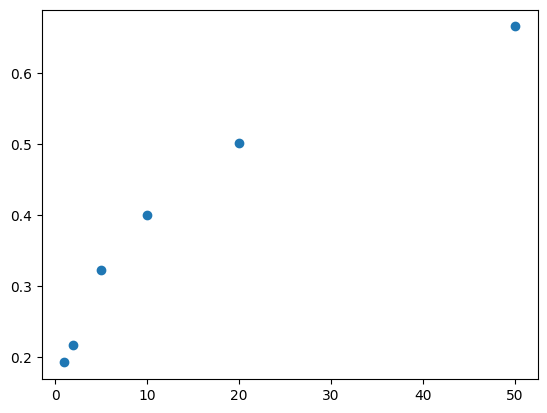

In [ ]:
plt.scatter(k_list, accuracies)
plt.plot()

We observe that as the Number of Clusters increases, the accuracy of predictions using the BoVW Approach also increases. But, after a fixed value of k (number of cluster centers), increase in accuracy of predictions reduces and it converges to an almost fixed value. But, for lower values of k, the increase is sharp. It points out the Limitations of Classification using SIFT Detector and Descriptor. However, still the SIFT Detector Approach is able to Capture amost 70% of features which is a decent accuracy given the fact that it's execution time is very low. So, if we want to only know the regions of local features, SIFT Detector and Descriptor gives us a fair idea of that.

##### 1.3 Impact of different Hyperparameters #####

In [ ]:
import warnings
warnings.filterwarnings('ignore')
c_list = [1, 0.5, 1.5]
loss_list = ['squared_hinge', 'hinge']
k = 50
accuracies = []
for c in c_list:
    for loss_function in loss_list:
        print(f"C = {c}\tLoss Function = {loss_function}", end = '\t')

        # Fit K-Means on the obtained Descriptors
        kmeans, cluster_centers = cluster_sift_descriptors(np.array(descriptors), k)

        # Represent Train images as histograms
        svm_train = []
        for i in range(train_dataset.data.shape[0]):
            histogram = image_histogram_represent(train_dataset.data[i], kmeans, k, cluster_centers=cluster_centers)
            svm_train.append(histogram)

        svm1 = make_pipeline(StandardScaler(), svm.LinearSVC(dual = 'auto', C = c, loss = loss_function))
        svm1.fit(svm_train, y_train)

        # Represent Test images as histograms
        svm_test = []
        for i in range(test_dataset.data.shape[0]):
            histogram = image_histogram_represent(test_dataset.data[i], kmeans, k, cluster_centers=cluster_centers)
            svm_test.append(histogram)

        # Find out the Classification Accuracy of the Model
        y_pred = svm1.predict(svm_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"-->\tAccuracy = {accuracy}")
        accuracies.append(accuracy)
accuracies

C = 1	Loss Function = squared_hinge	-->	Accuracy = 0.6535
C = 1	Loss Function = hinge	-->	Accuracy = 0.5994
C = 0.5	Loss Function = squared_hinge	-->	Accuracy = 0.6542
C = 0.5	Loss Function = hinge	-->	Accuracy = 0.5471
C = 1.5	Loss Function = squared_hinge	-->	Accuracy = 0.6444
C = 1.5	Loss Function = hinge	-->	Accuracy = 0.6431


[0.6535, 0.5994, 0.6542, 0.5471, 0.6444, 0.6431]

We observe that keeping the Number of Clusters constant from the above part (k = 50), Accuracies which are obtained by varying the Regularisation Parameter and Loss Function are more or less the same. It essentially means that the Number of Clusters (k) in this algorithm is the significant hyperparameter. As value of k increases, the Linear SVM along with K-means Clustering is able to capture the Local Regions of arious features in the Images which leads to better classification accuracies. Although, we observe that in general squared_hinge loss function (which is implemented as default in sklearn) outperforms hinge loss function in almost all the scenarios. The accuracies obtained using squared_hinge loss function are nearly 65% while those obtained by hinge loss function are generally around 55-60% with some exceptions of values of regularisation parameter C. However, in all cases, Accuracy of squared hinge loss function is greater than that of hinge loss function. So, in general, squared hinge loss function is better for classification than the hinge loss function.

### 2. CNNs and Vision Transformers

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
np.random.seed = 42
torch.manual_seed = 42

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)

# Split the training set into training and validation sets and make separate dataloaders for each
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
trainset, valset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

testset = MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

#### 2.1 Training MNIST with LeNet architecture

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, padding = 2, stride = 1),                   #(N, 1, 28, 28) -> (N, 6, 28, 28)
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),           #(N,6,28,28) -> (N,6,14,14)
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),                  #(N,6,14,14) -> (N,16,10,10)
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),            #(N,16,10,10) -> (N,16,5,5)
            nn.Flatten(1, 3),                    #(N,16,5,5) -> (N,400)
            nn.Linear(400, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10),
        )

    def forward(self, x):
        return self.cnn_model(x)

In [7]:
wandb.login()
wandb.init(
    project="CV_Assignment2-Q2",
    config={
        "optimizer": "gd",
        "loss": "crossentropy",
        "metric": "accuracy",
        "epoch": 1000
    }
)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pranav-g (pranavg1). Use `wandb login --relogin` to force relogin


In [9]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
model.train()

for epoch in range(10):
    correct = 0
    total = 0
    train_loss = 0
    for i, batch in enumerate(trainloader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x).to(device)
        loss = criterion(y_pred, y)
        _, predicted = torch.max(y_pred, 1)
        correct += (predicted == y).sum().item()
        total += y.shape[0]
        train_loss += loss
        loss.backward()
        optimizer.step()

    print(f"Epoch = {epoch}\tTraining Loss = {train_loss/len(trainset)}\tAccuracy = {(correct*100)/total}")
    wandb.log({"Epoch": epoch, "Average Training Loss: ": train_loss/len(trainset), "Training Accuracy: ": (correct*100)/total})


    val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(valloader):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            _, predicted = torch.max(y_pred, 1)
            correct += (predicted == y).sum().item()
            total += y.shape[0]
            val_loss += loss
    print(f"Epoch = {epoch}\tValidation Loss = {val_loss/len(valset)}\tAccuracy = {(correct*100)/total}")
    wandb.log({"Epoch": epoch, "Average Validation Loss: ": val_loss/len(valset), "Validation Accuracy: ": (correct*100)/total})

Epoch = 0	Training Loss = 0.005259239114820957	Accuracy = 90.27619047619048
Epoch = 0	Validation Loss = 0.002170537831261754	Accuracy = 92.005
Epoch = 1	Training Loss = 0.0017152332002297044	Accuracy = 96.62619047619047
Epoch = 1	Validation Loss = 0.001339772716164589	Accuracy = 96.85166666666667
Epoch = 2	Training Loss = 0.001109174219891429	Accuracy = 97.84285714285714
Epoch = 2	Validation Loss = 0.0011063007405027747	Accuracy = 97.84833333333333
Epoch = 3	Training Loss = 0.0008043526904657483	Accuracy = 98.42619047619047
Epoch = 3	Validation Loss = 0.0010261328425258398	Accuracy = 98.3
Epoch = 4	Training Loss = 0.0006159242475405335	Accuracy = 98.83809523809524
Epoch = 4	Validation Loss = 0.0009895190596580505	Accuracy = 98.61666666666666
Epoch = 5	Training Loss = 0.00047752956743352115	Accuracy = 99.08333333333333
Epoch = 5	Validation Loss = 0.0009834886295720935	Accuracy = 98.79
Epoch = 6	Training Loss = 0.0003872183442581445	Accuracy = 99.2452380952381
Epoch = 6	Validation Loss =

In [10]:
model.eval()
correct = 0
total = 0
test_loss = 0
for i, batch in enumerate(testloader):
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    y_pred = model(x).to(device)
    loss = criterion(y_pred, y)
    _, predicted = torch.max(y_pred, 1)
    correct += (predicted == y).sum().item()
    total += y.shape[0]
    test_loss += loss
print(f"Testing Loss = {test_loss/len(testset)}\tAccuracy = {(correct*100)/total}")
wandb.log({"Average Testing Loss: ": val_loss/len(valset), "Testing Accuracy: ": (correct*100)/total})

Testing Loss = 0.0010411626426503062	Accuracy = 98.24


In [11]:
wandb.finish()

Average Testing Loss:,▁
Average Training Loss:,██▃▂▂▂▁▁▁▁▁
Average Validation Loss:,█▃▂▂▁▁▁▂▁▂
Epoch,▁▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
Testing Accuracy:,▁
Training Accuracy:,▁▁▆▇▇▇█████
Validation Accuracy:,▁▆▇▇▇█████
Average Testing Loss:,0.00102
Average Training Loss:,0.00024
Average Validation Loss:,0.00102
Epoch,9


#### 2.2 Hyperparameter Tuning ####

In [16]:
def hyperparameter_tune(optimizer, criterion, trainloader, valloader, testloader):
    model.train()

    for epoch in range(10):
        correct = 0
        total = 0
        train_loss = 0
        for i, batch in enumerate(trainloader):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_pred = model(x).to(device)
            loss = criterion(y_pred, y)
            _, predicted = torch.max(y_pred, 1)
            correct += (predicted == y).sum().item()
            total += y.shape[0]
            train_loss += loss
            loss.backward()
            optimizer.step()

        val_loss = 0
        with torch.no_grad():
            for i, batch in enumerate(valloader):
                x, y = batch
                x = x.to(device)
                y = y.to(device)
                y_pred = model(x)
                loss = criterion(y_pred, y)
                _, predicted = torch.max(y_pred, 1)
                correct += (predicted == y).sum().item()
                total += y.shape[0]
                val_loss += loss

    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    for i, batch in enumerate(testloader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x).to(device)
        loss = criterion(y_pred, y)
        _, predicted = torch.max(y_pred, 1)
        correct += (predicted == y).sum().item()
        total += y.shape[0]
        test_loss += loss
    print(f"Testing Loss = {test_loss/len(testset)}\tAccuracy = {(correct*100)/total}")
    return correct*100/total

In [17]:
criterion = nn.CrossEntropyLoss()
accuracies = []
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
accuracies.append(hyperparameter_tune(optimizer=optimizer, criterion=criterion, trainloader=trainloader, valloader=valloader, testloader=testloader))

model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
accuracies.append(hyperparameter_tune(optimizer=optimizer, criterion=criterion, trainloader=trainloader, valloader=valloader, testloader=testloader))

model = CNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)
accuracies.append(hyperparameter_tune(optimizer=optimizer, criterion=criterion, trainloader=trainloader, valloader=valloader, testloader=testloader))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
accuracies.append(hyperparameter_tune(optimizer=optimizer, criterion=criterion, trainloader=trainloader, valloader=valloader, testloader=testloader))

model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
accuracies.append(hyperparameter_tune(optimizer=optimizer, criterion=criterion, trainloader=trainloader, valloader=valloader, testloader=testloader))

model = CNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)
accuracies.append(hyperparameter_tune(optimizer=optimizer, criterion=criterion, trainloader=trainloader, valloader=valloader, testloader=testloader))
accuracies

Testing Loss = 0.0013571350136771798	Accuracy = 97.38
Testing Loss = 0.0006915962439961731	Accuracy = 98.62
Testing Loss = 0.0326070636510849	Accuracy = 47.4
Testing Loss = 0.0021132458932697773	Accuracy = 97.81
Testing Loss = 0.0022312100045382977	Accuracy = 97.98
Testing Loss = 0.031440217047929764	Accuracy = 73.7


[97.38, 98.62, 47.4, 97.81, 97.98, 73.7]

We observe that as learning rate becomes closer to the optimal learning rate (in this case optimal learning is closer to 0.0001), it leads to faster convergence and therefore better convergence. Also, it is observed that Adam Optimizer outperforms the perfomance of SGD Optimizer since Adam Optimizer converges much faster than SGD Optimizer, and is more stable at the same time. With this we conclude that larger Batch Size leads to lower running time of the loops but leads to almost the same accuracy. At the same time, choice of Optimizer plays an important role for training any model and Adam Optimizer converges and produces great results in very short amount of epochs.

#### 2.3 Comparison ####
We notice that Best CNN Model gives much better results compared to Best SIFT-SVM BoVW Model. It is because CNN Model gives accuracy of 98-99% accuracies while, on the other hand, SIFT Model gives us accuracies of only 60-65%. SIFT Detector and Descriptor is not able to capture the localized features in any given region of the image to that extent as the CNN based Model, because convolution operators with different Kernels with the entire Image thus is able to capture the various localized regions in the image because of varied intensities and RGB Values of different pixels.

#### 2.4 Performance change as number of Convolutional Layers double ####

In [14]:
class CNN_new(nn.Module):
    def __init__(self):
        super(CNN_new,self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, padding = 2),             # (N, 1, 28, 28) -> (N, 6, 28, 28)
            nn.Tanh(),
            nn.Conv2d(in_channels = 6, out_channels = 6, kernel_size = 5, padding = 2),             # (N, 6, 28, 28) -> (N, 6, 28, 28)
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 2),                  # (N, 6, 28, 28) -> (N, 6, 14, 14)
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, padding = 0),            # (N, 6, 14, 14) -> (N, 16, 10, 10)
            nn.Tanh(),
            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5, padding = 2),           # (N, 16, 10, 10) -> (N, 16, 10, 10)
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 2),                  # (N, 16, 10, 10) -> (N, 16, 5, 5)
            nn.Flatten(1, 3),                   # (N, 16, 5, 5) -> (N, 400)
            nn.Linear(400, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        return self.cnn_model(x)

In [18]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
criterion = nn.CrossEntropyLoss()

model = CNN_new().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
hyperparameter_tune(optimizer=optimizer, criterion=criterion, trainloader=trainloader, valloader=valloader, testloader=testloader)

Testing Loss = 0.0015247208066284657	Accuracy = 98.57


98.57

We observe that on doubling the No. of Convolutional Layers, Accuracy remains almost the same, it remains almost the same and decreases slightly from 98.62% to 98.57%, which is almost the same. That is, the original LeNet Architecture alone is sufficient to capture the Local Features across all regions in the image and addition of extra convolutional layers only adds on to the No. of operations and does not contribute much to the feature capturing power of the model.

#### 2.5 Performance change with increase in training samples ####

In [20]:
def sample_mnist(x):
    X_train = []
    Y_train = []

    for i in range(10):
        class_indices = torch.where(train_dataset.targets == i)[0]
        class_samples = train_dataset.data[class_indices]
        y = []
        X_train.append(class_samples[:int(x/6)])
        [y.append(i) for _ in range(int(x/6))]
        Y_train.append(torch.tensor(y))
    return X_train, Y_train


class Custom_Subset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]

        if isinstance(x, torch.Tensor):
            x = transforms.ToPILImage()(x)

        if self.transform:
            x = self.transform(x)
        return x, y

In [19]:
criterion = nn.CrossEntropyLoss()
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
samples_l = np.array([600, 1800, 6000, 18000, 60000])
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
accuracies = []

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image
])

for n_samples in samples_l:
    print(f"Number of Training Samples = {n_samples}", end = "\t-->\t")
    X_train = None
    Y_train = None
    if (n_samples == 60000):
        X_train = train_dataset.data
        Y_train = train_dataset.targets
    else:
        x, y = sample_mnist(n_samples)
        x_train = torch.stack(x)
        y_train = torch.stack(y)
        X_train = x_train.view(x_train.shape[0]*x_train.shape[1], 28, 28)
        Y_train = y_train.view(y_train.shape[0]*y_train.shape[1])


    custom_dataset = Custom_Subset(x=X_train, y=Y_train, transform=transform)
    train_size = int(0.7 * len(custom_dataset))
    val_size = len(custom_dataset) - train_size
    train_set, val_set = torch.utils.data.random_split(custom_dataset, [train_size, val_size])
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=False)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)
    accuracy = hyperparameter_tune(optimizer=optimizer, criterion=criterion, trainloader=trainloader, valloader=valloader, testloader=testloader)
    accuracies.append(accuracy)
accuracies

Number of Training Samples = 600	-->	Testing Loss = 0.009114941582083702	Accuracy = 84.13
Number of Training Samples = 1800	-->	Testing Loss = 0.004188993945717812	Accuracy = 91.92
Number of Training Samples = 6000	-->	Testing Loss = 0.0019518779590725899	Accuracy = 96.01
Number of Training Samples = 18000	-->	Testing Loss = 0.0010700274724513292	Accuracy = 97.98
Number of Training Samples = 60000	-->	Testing Loss = 0.0009402282303199172	Accuracy = 98.4


[84.13, 91.92, 96.01, 97.98, 98.4]

We observe that as the Number of Training Samples increases, model is able to generalise better and the Accuracy on the Testing Set increase from 84% to 98%. This means that as the Number of Samples increases Model sees the Local Regions corresponding to different labels in a better fashion and is thus able to capture the Features in a better way, which leads to great generalisation on the Testing Set as well, leading to High Accuracies. However, after the certain point, the increase in number of training set size is not much and what matters is the Architecture of the Model and the Complexity of the Features to be captured in the Dataset.

#### 2.6 Vision Transformers ####

In [13]:
import math

class VIT(nn.Module):
    def __init__(self):
        super(VIT, self).__init__()
        self.linear_proj = nn.Linear(49, 32)
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model = 32, nhead = 4, batch_first = True), num_layers = 2)
        # self.encoders = nn.ModuleList([VIT_Encoder() for _ in range(2)])
        self.cls_token = nn.Parameter(torch.randn(1, 32)).to(device)

        self.mlp = nn.Linear(32, 10)
        self.create_pos_embed()
        return
    

    def create_pos_embed(self):
        self.pos_embeddings = torch.zeros(64, 17, 32, dtype = torch.float32, device = device)
        self.pos_embeddings.requires_grad = True
        with torch.no_grad():
            for j in range(17):
                for k in range(32):
                    self.pos_embeddings[:, j, k] = math.sin(j/math.pow(10000, k/32)) if k%2 == 0 else math.cos(j/math.pow(10000, (k-1)/32))
        return self.pos_embeddings


    def image_patches(self, x):
        n, c, h, w = x.shape
        num_patches = 4
        patches = torch.zeros(n, num_patches ** 2, h * w * c // num_patches ** 2).to(device)
        patch_size = h // num_patches

        for index, image in enumerate(x):
            for i in range(num_patches):
                for j in range(num_patches):
                    patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                    patches[index, i * num_patches + j] = patch.flatten()
        return patches


    def forward(self, x):
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)

        # Divide the image into patches and create Patch Embeddings
        self.patch_embeddings = self.image_patches(x)

        # Linear Projection of Patch Embeddings
        self.patch_embeddings = self.linear_proj(self.patch_embeddings)

        # Add a Class Token at the beginning
        self.patch_embeddings = torch.cat((cls_tokens, self.patch_embeddings), dim=1)

        # Add Position Embeddings to the Patch Embeddings
        self.patch_embeddings += self.pos_embeddings[: self.patch_embeddings.shape[0]]

        # Pass the Embeddings to the Transformer
        self.patch_embeddings = self.transformer(self.patch_embeddings)


        # Take the Learned Class Token representing the imformation of the Image
        self.patch_embeddings = self.patch_embeddings[:, 0, :]

        # Pass the Output Class Token to the MLP Head (Decoder)
        return self.mlp(self.patch_embeddings).to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
model = VIT().to(device)
optimizer = torch.optim.Adam(model.parameters())
model.train()

for epoch in range(30):
    correct = 0
    total = 0
    train_loss = 0
    for i, batch in enumerate(trainloader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x).to(device)
        loss = criterion(y_pred, y)
        _, predicted = torch.max(y_pred, 1)
        correct += (predicted == y).sum().item()
        total += y.shape[0]
        train_loss += loss
        loss.backward()
        optimizer.step()

    print(f"Epoch = {epoch}\tTraining Loss = {train_loss/len(trainset)}\tAccuracy = {(correct*100)/total}")


    val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(valloader):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x).to(device)
            loss = criterion(y_pred, y)
            _, predicted = torch.max(y_pred, 1)
            correct += (predicted == y).sum().item()
            total += y.shape[0]
            val_loss += loss
    print(f"Epoch = {epoch}\tValidation Loss = {val_loss/len(valset)}\tAccuracy = {(correct*100)/total}")

model.eval()
correct = 0
total = 0
test_loss = 0
for i, batch in enumerate(testloader):
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    y_pred = model(x).to(device)
    loss = criterion(y_pred, y)
    _, predicted = torch.max(y_pred, 1)
    correct += (predicted == y).sum().item()
    total += y.shape[0]
    test_loss += loss
print(f"Testing Loss = {test_loss/len(testset)}\tAccuracy = {(correct*100)/total}")

Epoch = 0	Training Loss = 0.014267203398048878	Accuracy = 69.00714285714285
Epoch = 0	Validation Loss = 0.005421002395451069	Accuracy = 75.22333333333333
Epoch = 1	Training Loss = 0.004641305189579725	Accuracy = 90.88809523809523
Epoch = 1	Validation Loss = 0.0037906812503933907	Accuracy = 91.445
Epoch = 2	Training Loss = 0.003372100880369544	Accuracy = 93.5047619047619
Epoch = 2	Validation Loss = 0.0031441771425306797	Accuracy = 93.65
Epoch = 3	Training Loss = 0.003012078581377864	Accuracy = 94.02857142857142
Epoch = 3	Validation Loss = 0.002916199853643775	Accuracy = 94.10333333333334
Epoch = 4	Training Loss = 0.002621325897052884	Accuracy = 94.86190476190477
Epoch = 4	Validation Loss = 0.002767516067251563	Accuracy = 94.73166666666667
Epoch = 5	Training Loss = 0.0023806574754416943	Accuracy = 95.35238095238095
Epoch = 5	Validation Loss = 0.0030075209215283394	Accuracy = 95.0
Epoch = 6	Training Loss = 0.0022212278563529253	Accuracy = 95.62857142857143
Epoch = 6	Validation Loss = 0.00

In [21]:
x, y = sample_mnist(6000)
x_train = torch.stack(x)
y_train = torch.stack(y)
X_train = x_train.view(x_train.shape[0]*x_train.shape[1], 28, 28)
Y_train = y_train.view(y_train.shape[0]*y_train.shape[1])

custom_dataset = Custom_Subset(x=X_train, y=Y_train, transform=transform)
train_size = int(0.7 * len(custom_dataset))
val_size = len(custom_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(custom_dataset, [train_size, val_size])
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=False)
valloader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()
model = VIT().to(device)
optimizer = torch.optim.Adam(model.parameters())
model.train()

for epoch in range(30):
    correct = 0
    total = 0
    train_loss = 0
    for i, batch in enumerate(trainloader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x).to(device)
        loss = criterion(y_pred, y)
        _, predicted = torch.max(y_pred, 1)
        correct += (predicted == y).sum().item()
        total += y.shape[0]
        train_loss += loss
        loss.backward()
        optimizer.step()

    print(f"Epoch = {epoch}\tTraining Loss = {train_loss/len(trainset)}\tAccuracy = {(correct*100)/total}")

    val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(valloader):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x).to(device)
            loss = criterion(y_pred, y)
            _, predicted = torch.max(y_pred, 1)
            correct += (predicted == y).sum().item()
            total += y.shape[0]
            val_loss += loss
    print(f"Epoch = {epoch}\tValidation Loss = {val_loss/len(valset)}\tAccuracy = {(correct*100)/total}")

model.eval()
correct = 0
total = 0
test_loss = 0
for i, batch in enumerate(testloader):
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    y_pred = model(x).to(device)
    loss = criterion(y_pred, y)
    _, predicted = torch.max(y_pred, 1)
    correct += (predicted == y).sum().item()
    total += y.shape[0]
    test_loss += loss
print(f"Testing Loss = {test_loss/len(testset)}\tAccuracy = {(correct*100)/total}")

Epoch = 0	Training Loss = 0.0055080596357584	Accuracy = 21.34285714285714
Epoch = 0	Validation Loss = 0.003913457505404949	Accuracy = 28.85
Epoch = 1	Training Loss = 0.0029454254545271397	Accuracy = 61.98571428571429
Epoch = 1	Validation Loss = 0.0021983040496706963	Accuracy = 65.21
Epoch = 2	Training Loss = 0.0018357711378484964	Accuracy = 77.64285714285714
Epoch = 2	Validation Loss = 0.0015178112080320716	Accuracy = 79.27
Epoch = 3	Training Loss = 0.001386373653076589	Accuracy = 83.67142857142858
Epoch = 3	Validation Loss = 0.0012853516964241862	Accuracy = 84.34
Epoch = 4	Training Loss = 0.001082634087651968	Accuracy = 87.32857142857142
Epoch = 4	Validation Loss = 0.0010933883022516966	Accuracy = 87.51
Epoch = 5	Training Loss = 0.000948504195548594	Accuracy = 89.25714285714285
Epoch = 5	Validation Loss = 0.0009630670538172126	Accuracy = 89.25
Epoch = 6	Training Loss = 0.0008459769305773079	Accuracy = 90.15714285714286
Epoch = 6	Validation Loss = 0.0008914180216379464	Accuracy = 90.22

Observations - We observe that as the Size of Training Set increases, Transformer is able to capture the dependencies of the local regions of the Images amongst themselves. So, if the size of training set increases, we can say that Model after observing the Entire Training Set learns how the various regions correspond to different labels. So, classification accuracies with 60K Sized Image Dataset is higher than those obtained with 6K Sized Dataset. The corresponding accuracies obtained are as follows - 98-99% for 60000 images, 94-95% for 6000 images. We can say that it is because Transformers are Data Hungry and require large datasets for the well functioning of Self-Attention Mechanism.
Also, we observe that corresponding accuracies are higher in case of CNNs because CNNs are computationally efficient and capture the Local Features in a very fast manner compared to Transformers. It is because Self-Attention requires a very huge amount of time compared to Convolutional Operators. So, for epochs in the range of 10-20 CNNs capture dependencies faster than Transformers because of the Higher Training time involved in case of Transformers and this is the reason that after these number of epochs, accuracies obtained in case of CNNs are higher. But, after a large number of epochs Transformers capture the Attention Scores of each of the Feature and result in better performance than CNNs in general. 